## Solving Travelling Salesman Problem using Ant Colony Optimization

### Necessary Imports

In [185]:
import random
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
def distance(i, j): 
    return abs(i - j)

def generate_random_cities(cities_count=10, x_max=100, y_max=100):
    City = complex
    cities = set()
    while len(cities) < cities_count:
        x, y = random.randint(0, x_max), random.randint(0,y_max)
        while((x,y) in cities):
            x, y = random.randint(0, x_max), random.randint(0,y_max)
        cities.add(City(x,y))
    return list(cities)

def brute_force_TSP(cities):
    start = cities[0]
    all_permutations = [[start] + list(p) for p in itertools.permutations(set(cities) - {start})]
#     all_permutations = itertools.permutations(cities-{start})
    sp = min(all_permutations, key=lambda path: sum([distance(path[i], path[i-1]) for i in range(len(path))]))
    c = sum([distance(sp[i], sp[i-1]) for i in range(len(sp))])
    return sp, c
    
def gen_cost_matrix(city_list):
    cm = []
    rnk = len(city_list)
    for i in range(rnk):
        r = []
        for j in range(rnk):
            r.append(distance(city_list[i], city_list[j]))
        cm.append(r)
    return cm
    

### Ant Colony Optimization

### Defining the Graph class

In [187]:
class Graph(object):
    def __init__(self, cost_matrix: list):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = len(cost_matrix)
        # noinspection PyUnusedLocal
        self.pheromone = [[1 / (self.rank * self.rank) for j in range(self.rank)] for i in range(self.rank)]

### Defining the Ant Colony Class

In [188]:
class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy
        self.gen_avg_costs = []
        self.gen_best_costs = []

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                curr_cost = []
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                curr_cost.append(ant.total_cost)
                
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            
            self.gen_best_costs.append(best_cost)
            self.gen_avg_costs.append(np.mean(curr_cost))
            
#             print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        return best_solution, best_cost

### Defining the Ant Class 

In [189]:
class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                                                                                            i] ** self.colony.beta
        # noinspection PyUnusedLocal
        probabilities = [0 for i in range(self.graph.rank)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

### Plotter

In [190]:
def plot_tour(tour, cost, approach=None, ax=None, figsize=(10,10)):
    cycle = tour + [tour[0]]    
    x,y = [c.real for c in cycle], [c.imag for c in cycle]
    
    label=True
    if len(cycle)>20:
        label=False
        
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    
    _ = sns.scatterplot(x,y, color='g', marker='o', s=150, ax=ax)
    _ = sns.scatterplot(x[:1],y[:1], color='r', marker='d', s=250, ax=ax)
    _ = ax.plot(x,y,'--', color='black')
    
    for i in range(len(tour)):
        if label:
            _ = ax.text(x[i]+0.9, y[i]+0.9, 'City {}'.format(i+1), fontsize=15)
        _ = ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]), arrowprops=dict(arrowstyle="-|>", facecolor='black'), size=20)
    
    if cost and approach:
        _ = ax.set_title('{}\nTotal Cost - {:.2f}'.format(approach, cost), fontsize=15)
    
    _ = ax.margins(.15)
    _ = ax.grid(True)
    return ax

### Run TSP

In [174]:
def run_tsp(n=10, brute_force=False, ax=None, figsize=(10,10)):
    cities = generate_random_cities(n)
    if brute_force:
        if brute_force<=10:
            bf_path, bf_cost = brute_force_TSP(cities)
        else:
            print('The brtue force value is more than 10')
            return 
    cost_matrix = gen_cost_matrix(cities)
    aco = ACO(ant_count=10, generations=100, alpha=1.0, beta=10.0, rho=0.5, q=10, strategy=2)
    graph = Graph(cost_matrix)
    aco_path_seq, aco_cost = aco.solve(graph)
    aco_path = [cities[i] for i in aco_path_seq]
    
    if brute_force:
        fig, ax = plt.subplots(1,2, figsize=figsize)
        bf_ax = plot_tour(bf_path, bf_cost, approach='{}-City Brute Force'.format(n), ax=ax[0])    
        plot_tour(aco_path, aco_cost, approach='{}-City ACO'.format(n), ax=ax[1])
    else:
#         fig, ax = plt.subplots(figsize=(10,10))
        if ax:
            plot_tour(aco_path, aco_cost, approach='{}-City ACO'.format(n), ax=ax)
        else:
            plot_tour(aco_path, aco_cost, approach='{}-City ACO'.format(n), figsize=figsize)
        
        
        

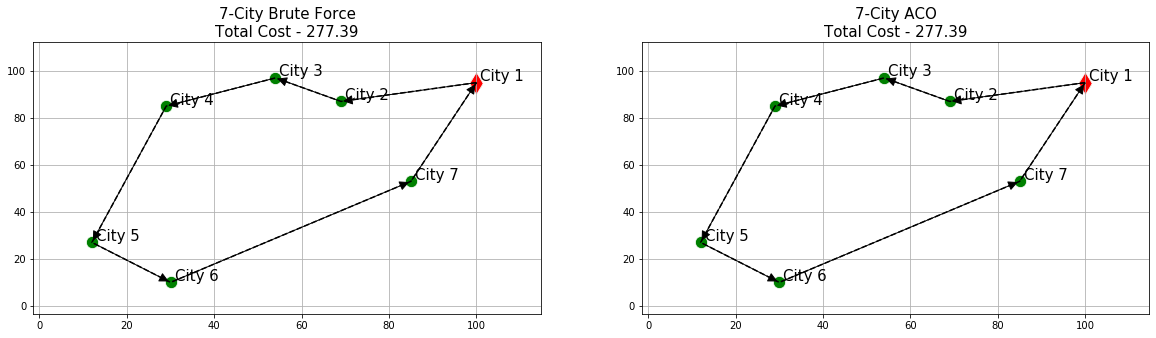

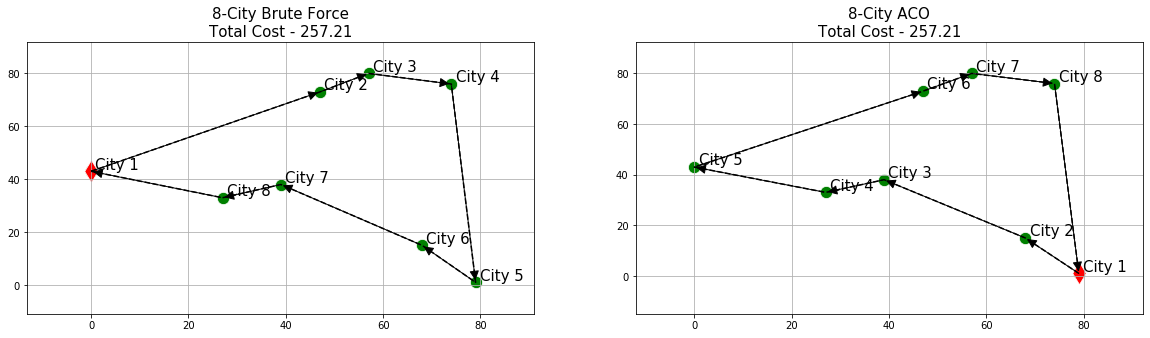

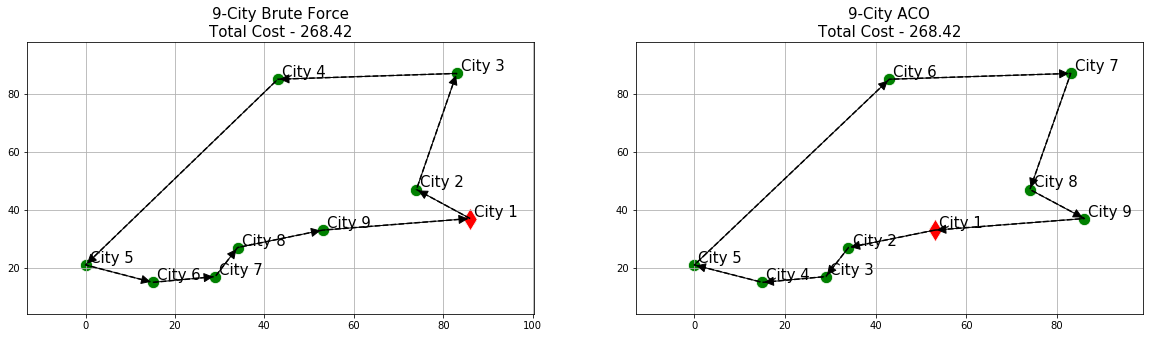

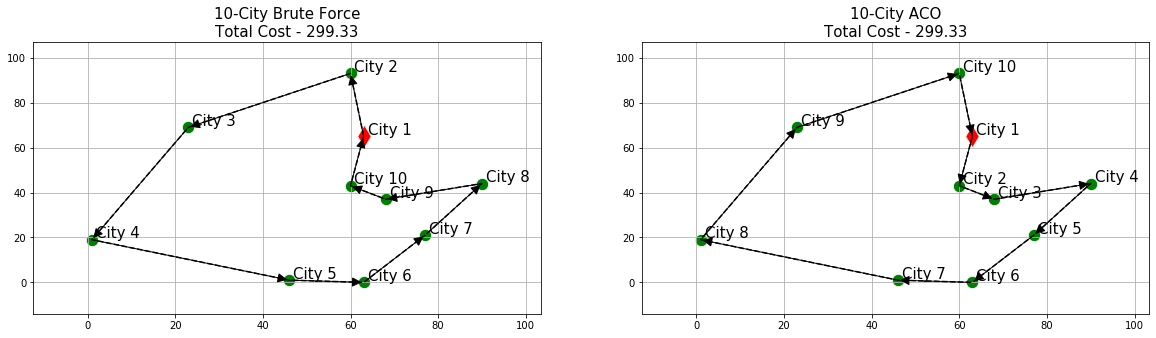

In [160]:
for i in range(7,11):
    run_tsp(n=i, brute_force=True, figsize=(20,5))

### Running ACO for upto 1000 cities 

CPU times: user 1h 53min 16s, sys: 35.1 s, total: 1h 53min 51s
Wall time: 2h 19min 58s


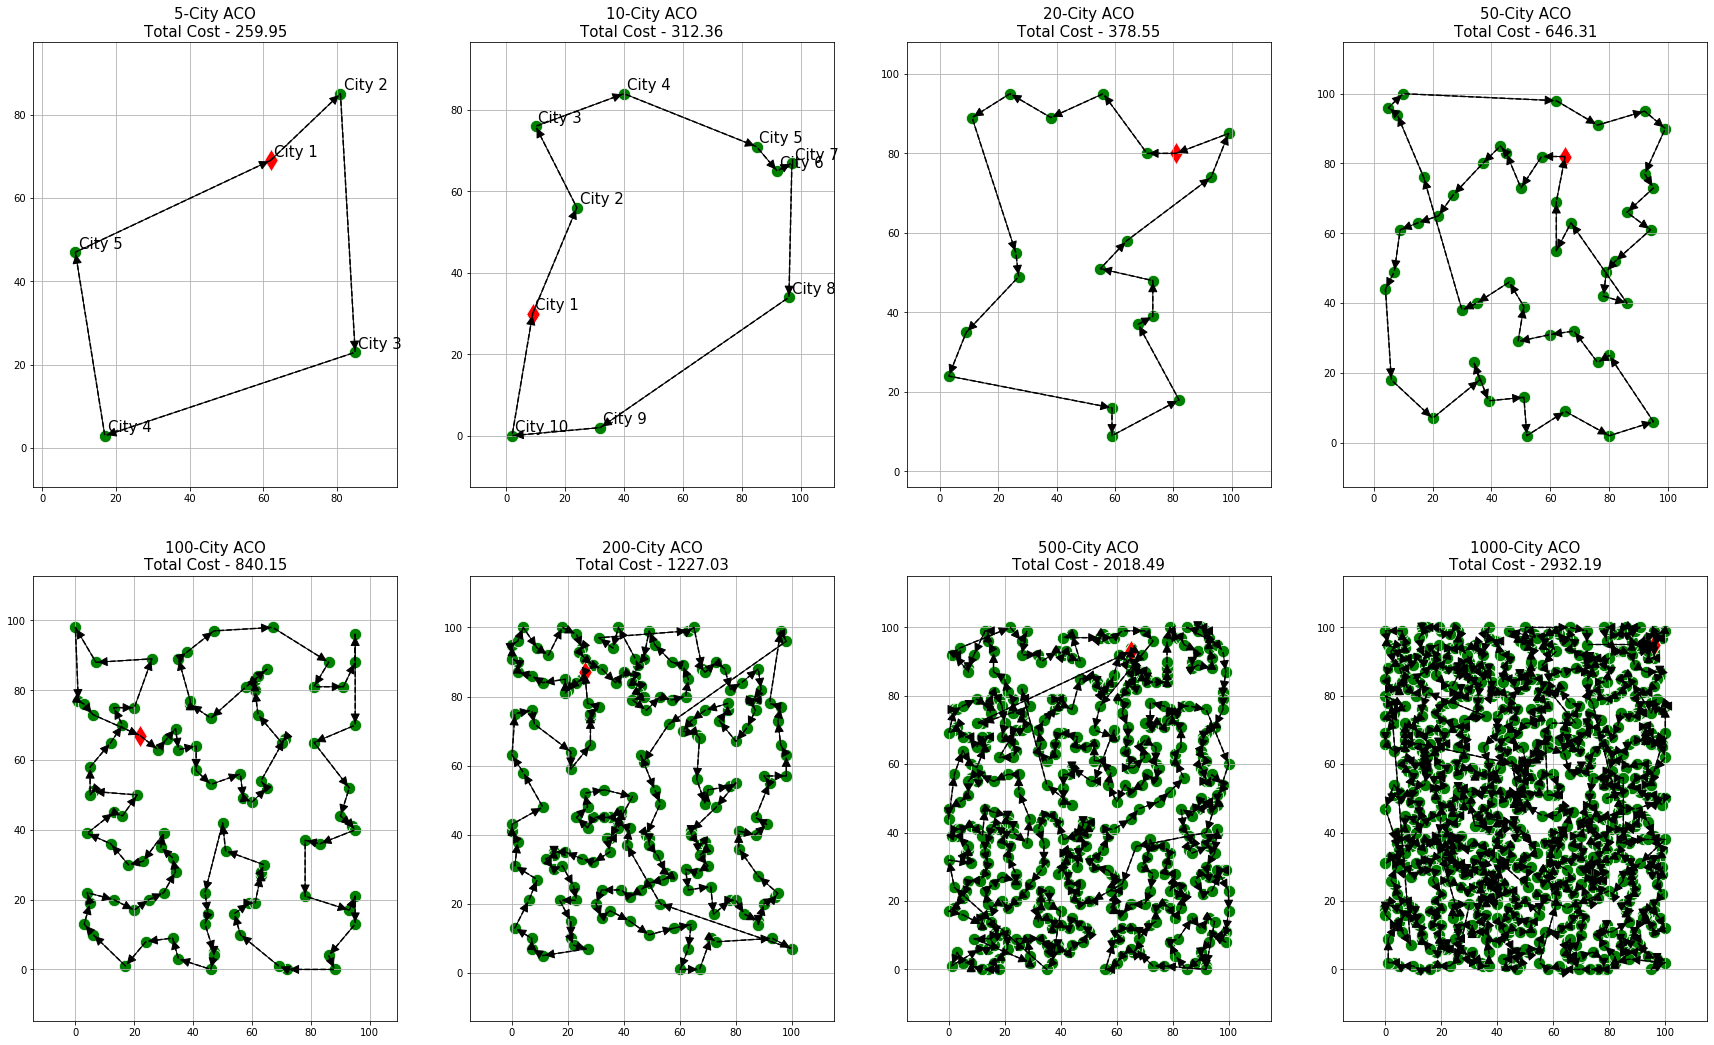

In [130]:
%%time
# city_count = [5]*8
city_count = [5, 10, 20, 50, 100, 200, 500, 1000]
fig, ax = plt.subplots(2,4, figsize=(30,18)); ax=ax.reshape(-1); i=0;
for n in city_count:
    run_tsp(n=n,brute_force=False, ax=ax[i])
    i+=1

In [133]:
fig.savefig('tsp-5-1000.png')

### ACO in depth

In [201]:
cities = generate_random_cities(cities_count=100)

### Best cost and Average cost across genrations

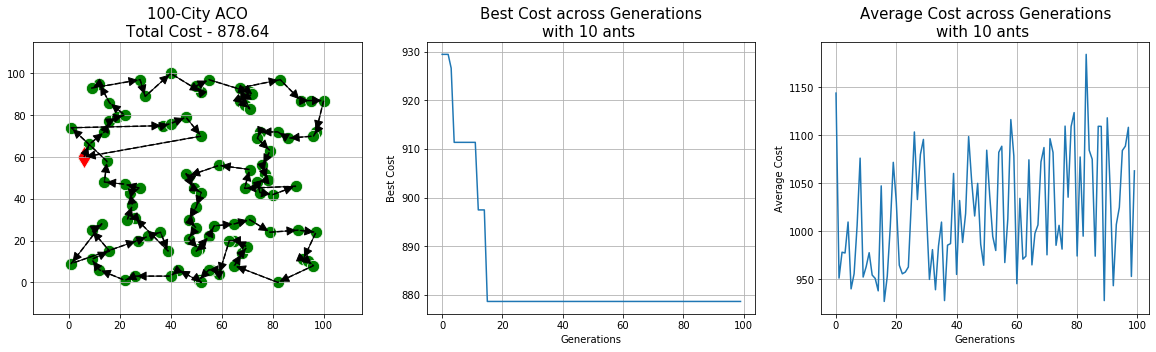

In [237]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

cost_matrix = gen_cost_matrix(cities)
aco = ACO(ant_count=10, generations=100, alpha=1.0, beta=10.0, rho=0.5, q=10, strategy=2)
graph = Graph(cost_matrix)
aco_path_seq, aco_cost = aco.solve(graph)

aco_path = [cities[i] for i in aco_path_seq]
plot_tour(aco_path, aco_cost, approach='{}-City ACO'.format(graph.rank), ax=ax[0])

x = [i for i in range(aco.generations)]
y = aco.gen_best_costs
_ = sns.lineplot(x,y, ax=ax[1])
_ = ax[1].set_title("Best Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[1].set_ylabel("Best Cost")
_ = ax[1].set_xlabel("Generations")
_ = ax[1].grid(True)

x = [i for i in range(aco.generations)]
y = aco.gen_avg_costs
_ = sns.lineplot(x,y, ax=ax[2])
_ = ax[2].set_title("Average Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[2].set_ylabel("Average Cost")
_ = ax[2].set_xlabel("Generations")
_ = ax[2].grid(True)

### Comparision with GA

In [310]:
from deap import algorithms, base, creator, tools

In [311]:
random.seed(0)
cities = generate_random_cities(cities_count=100)

Fitness of the best individual:  1280.488523353867


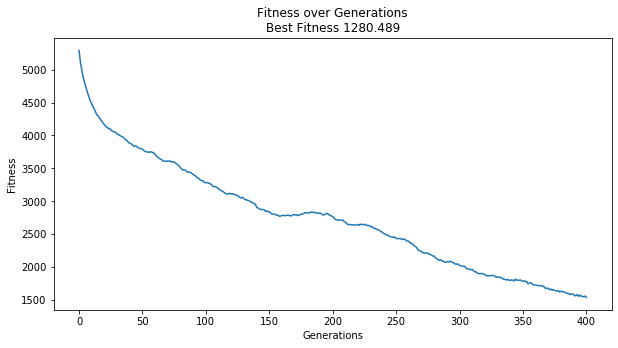

In [312]:
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox.register("indices", np.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ordered crossover
toolbox.register("mate", tools.cxOrdered)

# For mutation we will swap elements from two points of the individual. acheive using shuffle index
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

def evaluation(individual):
    sp = [cities[idx] for idx in individual]
    c = sum([distance(sp[i], sp[i-1]) for i in range(len(sp))])
    return (c,)

toolbox.register("evaluate", evaluation)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.1, ngen=400, verbose=False, stats=stats, halloffame=hof)


best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

gen, avg = log.select("gen", "avg")
plt.figure(figsize=(10,5))
plt.plot(gen, avg)
plt.title('Fitness over Generations\nBest Fitness {:.3f}'.format(evaluation(best_individual)[0]))
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

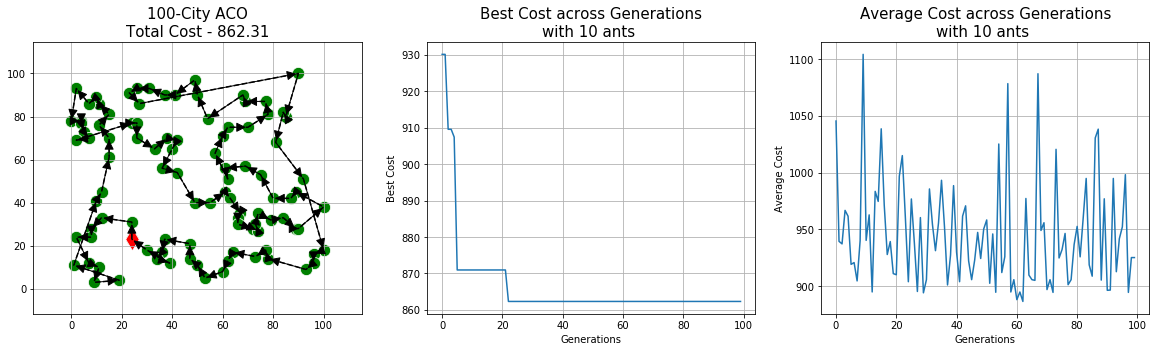

In [313]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

cost_matrix = gen_cost_matrix(cities)
aco = ACO(ant_count=10, generations=100, alpha=1.0, beta=10.0, rho=0.5, q=10, strategy=2)
graph = Graph(cost_matrix)
aco_path_seq, aco_cost = aco.solve(graph)

aco_path = [cities[i] for i in aco_path_seq]
plot_tour(aco_path, aco_cost, approach='{}-City ACO'.format(graph.rank), ax=ax[0])

x = [i for i in range(aco.generations)]
y = aco.gen_best_costs
_ = sns.lineplot(x,y, ax=ax[1])
_ = ax[1].set_title("Best Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[1].set_ylabel("Best Cost")
_ = ax[1].set_xlabel("Generations")
_ = ax[1].grid(True)

x = [i for i in range(aco.generations)]
y = aco.gen_avg_costs
_ = sns.lineplot(x,y, ax=ax[2])
_ = ax[2].set_title("Average Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[2].set_ylabel("Average Cost")
_ = ax[2].set_xlabel("Generations")
_ = ax[2].grid(True)

### Effect of number of ants 

CPU times: user 6min 7s, sys: 3.18 s, total: 6min 10s
Wall time: 6min 19s


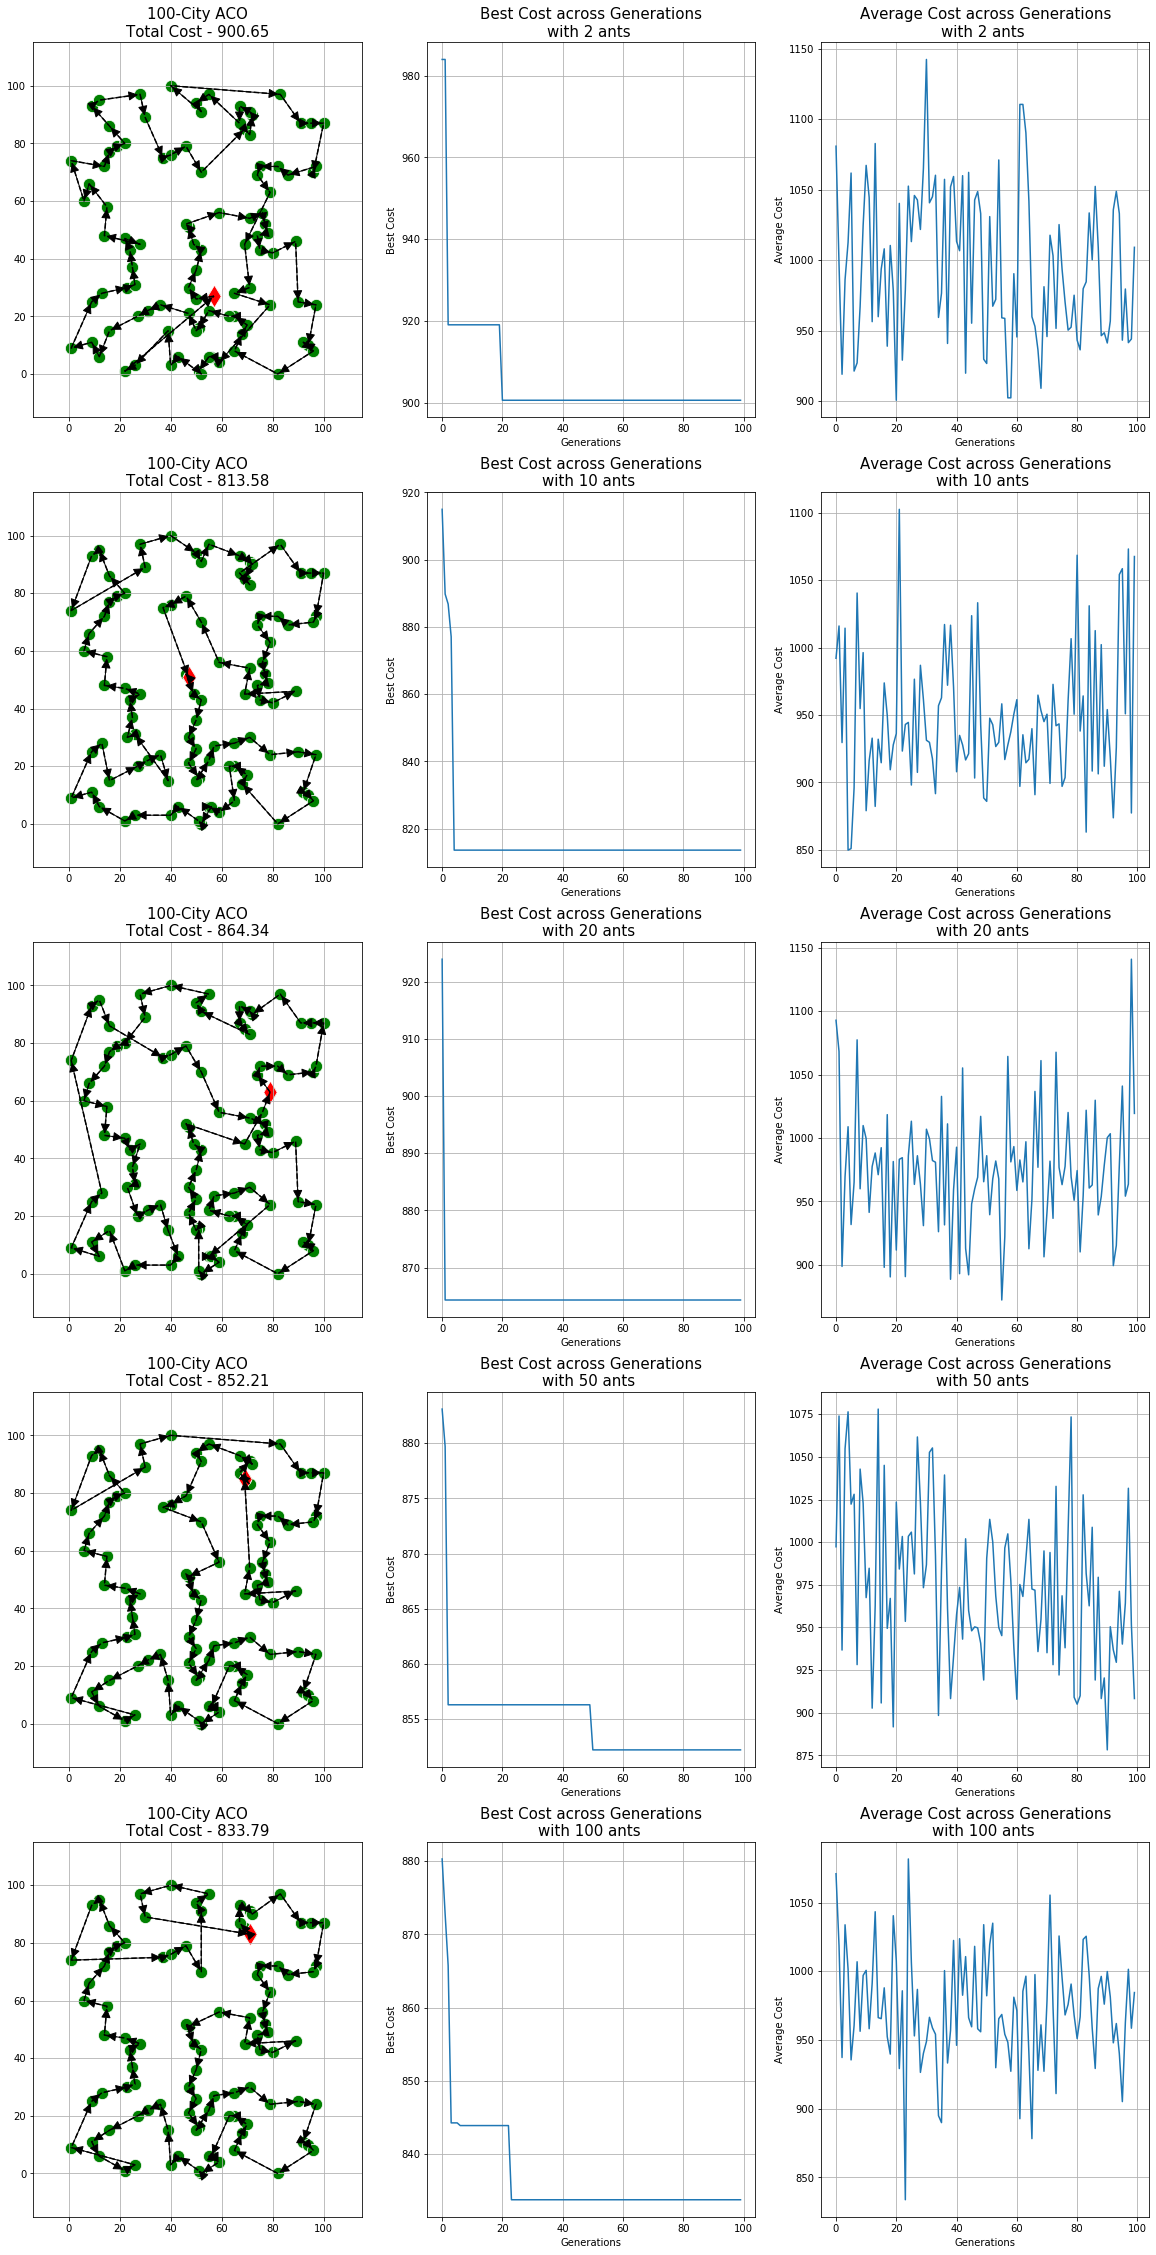

In [238]:
%%time

ant_range = [2, 10, 20, 50, 100]
fig, ax = plt.subplots(len(ant_range),3,figsize=(20,40))

for idx, ants in enumerate(ant_range):
    cost_matrix = gen_cost_matrix(cities)
    aco = ACO(ant_count=ants, generations=100, alpha=1.0, beta=10.0, rho=0.5, q=10, strategy=2)
    graph = Graph(cost_matrix)
    aco_path_seq, aco_cost = aco.solve(graph)
    
    aco_path = [cities[i] for i in aco_path_seq]
    plot_tour(aco_path, aco_cost, approach='{}-City ACO'.format(graph.rank), ax=ax[idx,0])

    x = [i for i in range(aco.generations)]
    y = aco.gen_best_costs
    _ = sns.lineplot(x,y, ax=ax[idx,1])
    _ = ax[idx,1].set_title("Best Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
    _ = ax[idx,1].set_ylabel("Best Cost")
    _ = ax[idx,1].set_xlabel("Generations")
    _ = ax[idx,1].grid(True)

    x = [i for i in range(aco.generations)]
    y = aco.gen_avg_costs
    _ = sns.lineplot(x,y, ax=ax[idx,2])
    _ = ax[idx,2].set_title("Average Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
    _ = ax[idx,2].set_ylabel("Average Cost")
    _ = ax[idx,2].set_xlabel("Generations")
    _ = ax[idx,2].grid(True)

### berlin52 Dataset

In [266]:
cities_berlin = []
with open('./data/berlin52.tsp.txt', 'r') as f:
    City = complex
    for line in f.readlines()[6:-2]:
        city = line.split(' ')
        cities_berlin.append(City(float(city[1]), float(city[2])))

##### optimal so far

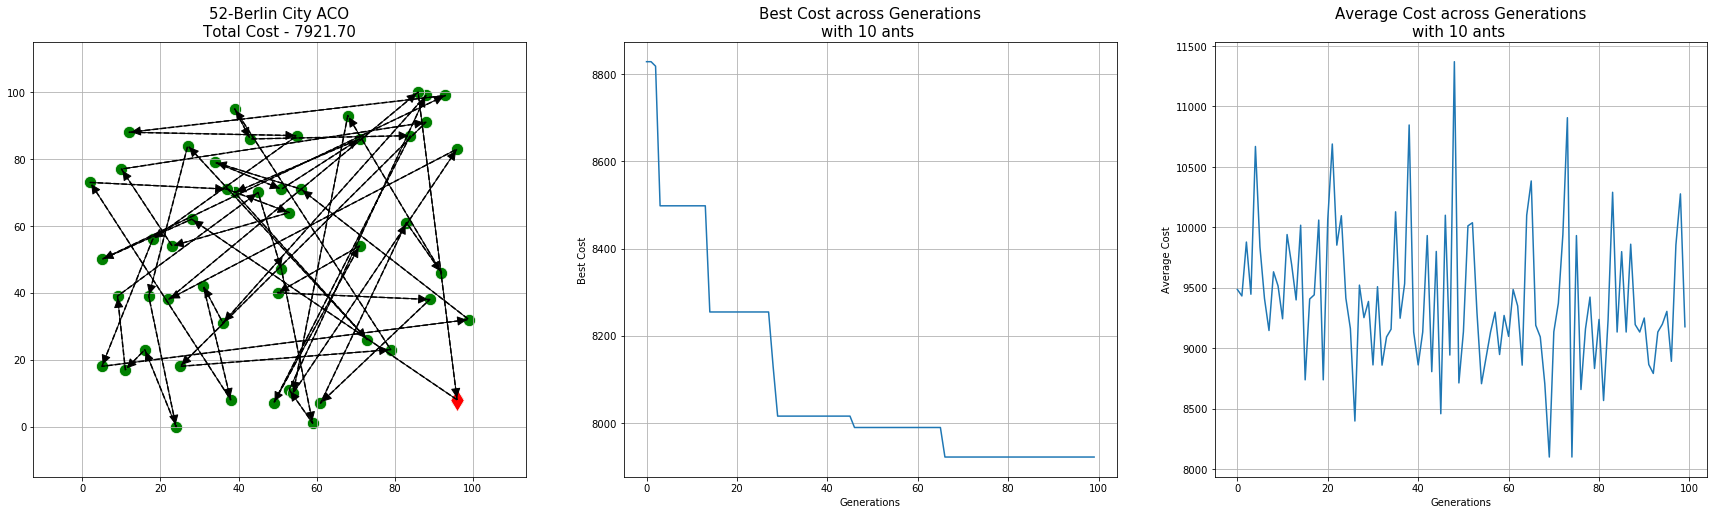

In [265]:
fig, ax = plt.subplots(1,3,figsize=(30,8))

cost_matrix = gen_cost_matrix(cities_berlin)
aco = ACO(ant_count=10, generations=100, alpha=1.0, beta=10.0, rho=0.5, q=10, strategy=2)
graph = Graph(cost_matrix)
aco_path_seq, aco_cost = aco.solve(graph)

aco_path = [cities[i] for i in aco_path_seq]
plot_tour(aco_path, aco_cost, approach='{}-Berlin City ACO'.format(graph.rank), ax=ax[0])

x = [i for i in range(aco.generations)]
y = aco.gen_best_costs
_ = sns.lineplot(x,y, ax=ax[1])
_ = ax[1].set_title("Best Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[1].set_ylabel("Best Cost")
_ = ax[1].set_xlabel("Generations")
_ = ax[1].grid(True)

x = [i for i in range(aco.generations)]
y = aco.gen_avg_costs
_ = sns.lineplot(x,y, ax=ax[2])
_ = ax[2].set_title("Average Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[2].set_ylabel("Average Cost")
_ = ax[2].set_xlabel("Generations")
_ = ax[2].grid(True)

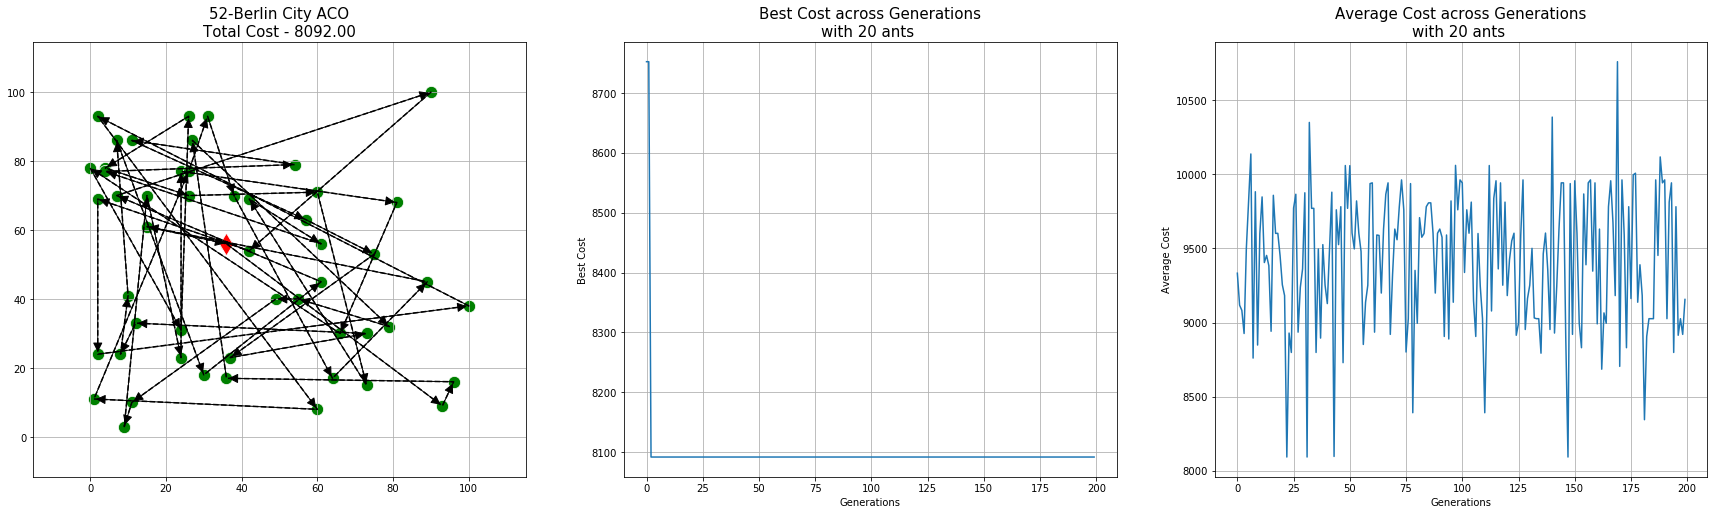

In [307]:
def gen_cost_matrix_round(city_list):
    cm = []
    rnk = len(city_list)
    for i in range(rnk):
        r = []
        for j in range(rnk):
            r.append(round(distance(city_list[i], city_list[j])))
        cm.append(r)
    return cm

fig, ax = plt.subplots(1,3,figsize=(30,8))

cost_matrix = gen_cost_matrix_round(cities_berlin)
aco = ACO(ant_count=20, generations=200, alpha=1.0, beta=20.0, rho=0.15, q=10, strategy=2)
graph = Graph(cost_matrix)
aco_path_seq, aco_cost = aco.solve(graph)

aco_path = [cities[i] for i in aco_path_seq]
plot_tour(aco_path, aco_cost, approach='{}-Berlin City ACO'.format(graph.rank), ax=ax[0])

x = [i for i in range(aco.generations)]
y = aco.gen_best_costs
_ = sns.lineplot(x,y, ax=ax[1])
_ = ax[1].set_title("Best Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[1].set_ylabel("Best Cost")
_ = ax[1].set_xlabel("Generations")
_ = ax[1].grid(True)

x = [i for i in range(aco.generations)]
y = aco.gen_avg_costs
_ = sns.lineplot(x,y, ax=ax[2])
_ = ax[2].set_title("Average Cost across Generations\nwith {} ants ".format(aco.ant_count), fontsize=15)
_ = ax[2].set_ylabel("Average Cost")
_ = ax[2].set_xlabel("Generations")
_ = ax[2].grid(True)